<a href="https://colab.research.google.com/github/SamHollings/covid19_analysis/blob/main/Cambridge_CPAS_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of Cambridge CPAS paper
I'm going to work through the Cambridge CPAS paper taking notes on the various bits for later reference
https://arxiv.org/pdf/2007.13825.pdf


## Get the data

Below are a bunch of functions to pull the NHSE API data (tests, cases, admissions, ventilated beds) for national right down to lower tier local authority. There are also functions to grab the google and apple mobility data:
- df_england_nhse_feed
- df_gb_google_mobility_report
- df_apple_mobility_report

### Import from gitlab

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
# if the Python/covid19_analysis dir dioesn't exist in your google drive, this will make it.
if not os.path.exists("gdrive/My Drive/Python/covid19_analysis/"):
  os.makedirs("gdrive/My Drive/Python/", exist_ok = True)
  %cd gdrive/My Drive/Python
  !git clone https://github.com/SamHollings/covid19_analysis.git
# pull the latest info from the github repo
%cd gdrive/My Drive/Python/covid19_analysis/
!git pull

/content/gdrive/My Drive/Python/covid19_analysis
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 5), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/SamHollings/covid19_analysis
   06d9748..49add84  main       -> origin/main
Updating 06d9748..49add84
Fast-forward
 Cambridge_CPAS_paper.ipynb | 800 +++------------------------------------------
 covid_data.py              | 115 +++----
 2 files changed, 101 insertions(+), 814 deletions(-)


In [ ]:
import covid_data
import data_tools
import plot_tools
import ARIMA_tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### pull the data

In [ ]:
covid_data_blob = covid_data.covid_england_data_blob(utla=False, ltla=False)

df_england_nhse_feed =  covid_data_blob['england_nhse']
df_uk_wide_nhse_feed = covid_data_blob['uk_nhse']
df_nhsregion_nhse_feed = covid_data_blob['nhsregion_nhse']
df_region_nhse_feed = covid_data_blob['region_nhse']
# df_utla_nhse_feed = covid_data_blob['utla_nhse']
# df_ltla_nhse_feed = covid_data_blob['ltla_nhse']
df_gb_google_mobility_report = covid_data_blob['google_mobility']
df_apple_mobility_report = covid_data_blob['apple_mobility']

areaType=nation;areaName=england page 1: https://api.coronavirus.data.gov.uk/v1/data?filters=areaType%3Dnation%3BareaName%3Dengland&structure=%7B%22date%22%3A%22date%22%2C%22areatype%22%3A%22areaType%22%2C%22name%22%3A%22areaName%22%2C%22code%22%3A%22areaCode%22%2C%22newCasesByPublishDate%22%3A%22newCasesByPublishDate%22%2C%22cumCasesByPublishDate%22%3A%22cumCasesByPublishDate%22%2C%22cumCasesBySpecimenDateRate%22%3A%22cumCasesBySpecimenDateRate%22%2C%22newCasesBySpecimenDate%22%3A%22newCasesBySpecimenDate%22%2C%22cumCasesBySpecimenDate%22%3A%22cumCasesBySpecimenDate%22%2C%22maleCases%22%3A%22maleCases%22%2C%22femaleCases%22%3A%22femaleCases%22%2C%22newPillarOneTestsByPublishDate%22%3A%22newPillarOneTestsByPublishDate%22%2C%22cumPillarOneTestsByPublishDate%22%3A%22cumPillarOneTestsByPublishDate%22%2C%22newPillarTwoTestsByPublishDate%22%3A%22newPillarTwoTestsByPublishDate%22%2C%22cumPillarTwoTestsByPublishDate%22%3A%22cumPillarTwoTestsByPublishDate%22%2C%22newPillarThreeTestsByPublishDa

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Load some more data from various sites, can't remember if these are even used!!

In [ ]:
df_sitrep_Feb2020 = pd.read_excel('https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/04/MSitRep-February-2020-alHTC.xls',sheet_name="Critical Care Beds",header=14).dropna(how="all",axis=1).dropna(how="all",axis=0)
weekly_admissions_url = "https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/10/Weekly-covid-admissions-publication-201029-2.xlsx"
df_nhse_weekly_covid19_admissions = pd.DataFrame([pd.read_excel(weekly_admissions_url, sheet_name = sheet,header=14).dropna(how="all",axis=1).dropna(how="all",axis=0)
                                                                                .set_index(['NHS England Region', 'Code', 'Name']).rename_axis('date',axis=1).stack().rename(sheet) 
              for sheet in ['Hosp ads & diag','New hosp cases','Hosp ads from comm','Hosp ads from comm with lag', 'Care home ads and diags','All beds COVID','MV beds COVID']]).T
df_nhse_weekly_covid19_admissions.to_csv("nhse_weekly_covid19_admissions_201029.csv")
weekly_admissions_list = ["201029"]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/multi.py:3369: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  uniq_tuples = lib.fast_unique_multiple([self._values, other._values], sort=sort)


Create the **newCasesBySpecDatePositiveRate** - more useful than raw positive test numbers

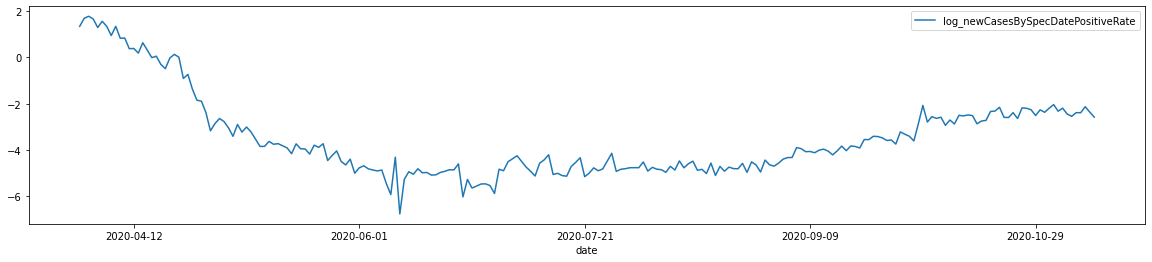

In [ ]:
df_uk_wide_nhse_feed['newCasesBySpecDatePositiveRate'] = df_uk_wide_nhse_feed.set_index('date')['newCasesByPublishDate'] / df_uk_wide_nhse_feed.set_index('date')['newPillarTwoTestsByPublishDate']
df_england_nhse_feed['log_newCasesBySpecDatePositiveRate'] = (df_england_nhse_feed.set_index('date')['newCasesByPublishDate']
                                        .div(df_uk_wide_nhse_feed.set_index('date')['newPillarTwoTestsByPublishDate'],axis=0)
                                        ).apply(np.log).values
ax = df_england_nhse_feed.set_index('date')['log_newCasesBySpecDatePositiveRate'].plot(legend=True, figsize=(20,4));

## Cambridge Model

### General Model Structure

mobility(t) -> GP(mu, K) -> beta(t)    

beta(t) -> hospital_admissions_model(t) -> H(t)

t -> GP(A(t), K) -> A(t)

## Simple Admissions Model
The core of this is an admissions model, which takes in some measure of contact rate (as a leading indicator) and then outputs predicted hospital admissions. Reasonable to start with a SARIMAX.

Start with **NHS_england mech vent beds** as the thing we want to predict.
Exogenous factors we will consider: 
- hospital cases, 
- hospital admissions
- positive tests (newCases...)

In [ ]:
# Parameters for the forecast:
number_days_forecast = 10 # days to predict at the end, after testing!
number_days_test = 10 # days taken off the end for testing

In [ ]:
df_england_mv_beds = covid_data.interpolate_early_data(df_england_nhse_feed['covidOccupiedMVBeds'])
# get date index back:
df_england_mv_beds.index = pd.to_datetime(df_england_nhse_feed['date']).iloc[df_england_mv_beds.index[0]:df_england_mv_beds.index[-1]]

df_england_hospital = covid_data.interpolate_early_data(df_england_nhse_feed['hospitalCases'])
# get date index back:
df_england_hospital.index = pd.to_datetime(df_england_nhse_feed['date']).iloc[df_england_hospital.index[0]:df_england_hospital.index[-1]]

df_england_admissions = covid_data.interpolate_early_data(df_england_nhse_feed['newAdmissions'])
# get date index back:
df_england_admissions.index = pd.to_datetime(df_england_nhse_feed['date']).iloc[df_england_admissions.index[0]:df_england_admissions.index[-1]]


# standardise positive rate between 0 and 1 and also fill in the early data by interpolation
df_england_positive = df_england_nhse_feed['log_newCasesBySpecDatePositiveRate'].rolling(3).mean()
df_england_positive = pd.Series((df_england_positive+np.abs(df_england_positive.min()))/ (df_england_positive.max()+np.abs(df_england_positive.min())))
df_england_positive = covid_data.interpolate_early_data(df_england_positive, [-60,-40])
# get date index back:
df_england_positive.index = pd.to_datetime(df_england_nhse_feed['date']).iloc[df_england_positive.index[0]:df_england_positive.index[-1]]

Combine the data into one dataframe - makes it easier to track and know what we are dealing with. The **"forecast"** becomes a future bit which currently has empty values.

In [ ]:
df_y = df_england_mv_beds.to_frame()
df_X = pd.concat([df_england_hospital, df_england_admissions, df_england_positive],axis=1,join='outer')

df_data = df_y.join(df_X, how="outer")
df_data['type'] = 'actual'
df_data["train_test"] = 'train'
df_data.iloc[-1*number_days_test:]["train_test"] = 'test'
df_forecast = pd.DataFrame(columns = df_data.columns, index = pd.date_range(df_data.index[-1] + pd.Timedelta(days=1),df_data.index[-1] + pd.Timedelta(days=number_days_forecast)))
df_forecast['train_test'] = 'forecast'
df_forecast['type'] = 'forecast'

df_data = pd.concat([df_data, df_forecast],axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


We need to use cross-correlation to find out how many lags are required to line up the data we want to predict with, against the data we want to predict (mechanically ventilated beds). We need to use just the actual, and drop and "na" as it breaks the statstools function. 

We find below that **log_newCasesBySpecDatePositiveRate** lagged by 14 days matches up with mech beds the best - so we will lag this by 14 days and use this as an exogenous factor

Optimum offset (lag) between covidOccupiedMVBeds and log_newCasesBySpecDatePositiveRate: 14
Optimum offset (lag) between covidOccupiedMVBeds and hospitalCases: 2
Optimum offset (lag) between covidOccupiedMVBeds and newAdmissions: 11


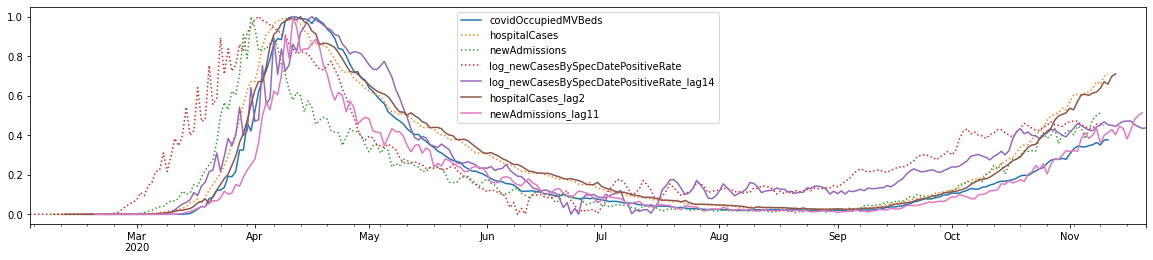

In [ ]:
# make lagged columns
lag_newcases = data_tools.find_optimum_lags(df_data[df_data['type']=='actual'][['covidOccupiedMVBeds','log_newCasesBySpecDatePositiveRate']])
lag_hospcases = data_tools.find_optimum_lags(df_data[df_data['type']=='actual'][['covidOccupiedMVBeds','hospitalCases']])
lag_hospadmiss = data_tools.find_optimum_lags(df_data[df_data['type']=='actual'][['covidOccupiedMVBeds','newAdmissions']])
df_data[f'log_newCasesBySpecDatePositiveRate_lag{lag_newcases}'] = df_data['log_newCasesBySpecDatePositiveRate'].shift(lag_newcases)
df_data[f'hospitalCases_lag{lag_hospcases}'] = df_data['hospitalCases'].shift(lag_hospcases)
df_data[f'newAdmissions_lag{lag_hospadmiss}'] = df_data['newAdmissions'].shift(lag_hospadmiss)

# plot the data (all set to show between 0 and 1)
data_tools.min_max_scale_df(df_data.drop(columns=['train_test','type'])).plot(figsize=(20,4), style=['-', ':', ':',':','-','-','-'],legend=True);

See this guide: https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


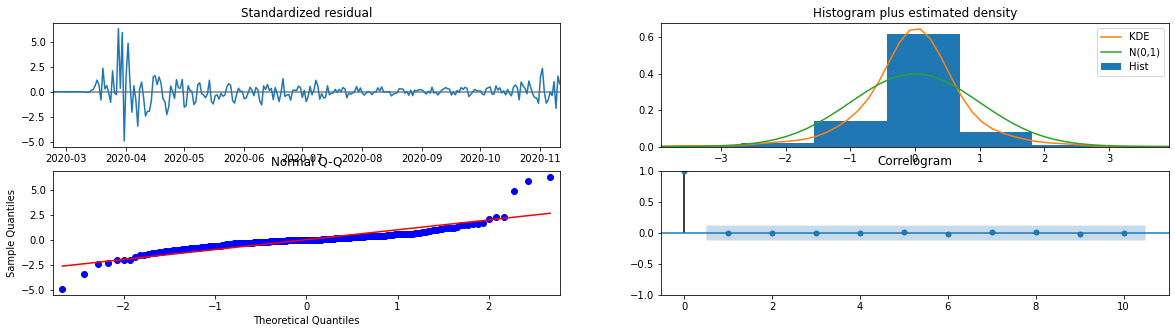

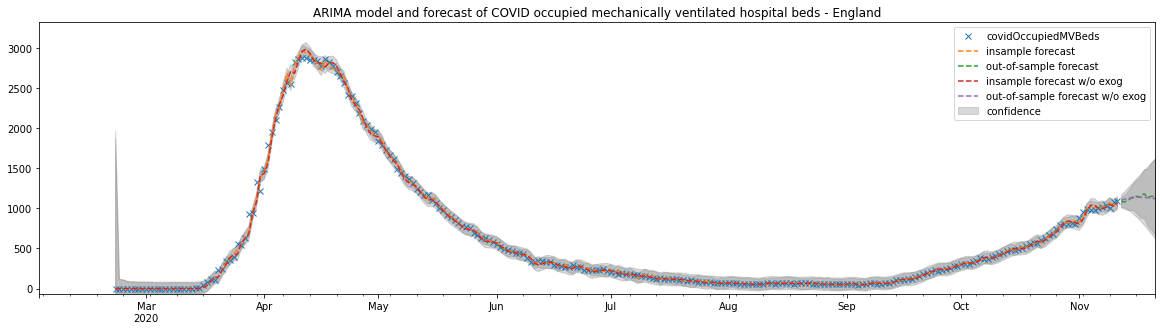

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# set the modelling parameters
endog_name = 'covidOccupiedMVBeds'
exog_name = f'log_newCasesBySpecDatePositiveRate_lag{lag_newcases}'
order=(30, 1, 10)

# get just the actual part of the data (i.e. not the forecast) and drop any NA rows
df_actual = df_data[df_data['type'] == 'actual'].copy()[[endog_name,exog_name]].dropna(how='any')
endogenous_actual = df_actual[endog_name]
exogenous_actual = df_actual[exog_name]
exogenous_forecast = df_data[df_data['type'] == 'forecast'].copy()[exog_name]

# define the model
model = SARIMAX(endog=endogenous_actual, exog=exogenous_actual, order=order)
model2 = SARIMAX(endog=endogenous_actual, order=(5,0,0))

# fit the model to the data
model_fit = model.fit();
model_fit.plot_diagnostics(figsize=(20,5))
model_fit.summary()
model2_fit = model2.fit()

# make the "in-sample" predictions - I.e. a sort of 1 day backfit
predict = model_fit.get_prediction()
predict2 = model2_fit.get_prediction()
# make the "out-of-sample" predictions - I.e. the future predictions]
forecast = model_fit.get_forecast(exog=np.atleast_2d(exogenous_forecast).T, steps=len(exogenous_forecast))
forecast2 = model2_fit.get_forecast(steps=len(exogenous_forecast))

# plot the results
fig, ax = plt.subplots(figsize=(20, 5))
df_data[endog_name].plot(ax=ax, marker='x', linewidth=0)  # actual data measured
df_insample_preds = ARIMA_tools.plot_arima_predictions(predict, label='insample forecast')  # in sample forecast - the fit of the model the data
df_future_preds = ARIMA_tools.plot_arima_predictions(forecast, label='out-of-sample forecast',ci_label=None)  # out-of-sample-forecast - the forecast of the future
df_insample_preds2 = ARIMA_tools.plot_arima_predictions(predict2, label='insample forecast w/o exog',ci_label=None)  # in sample forecast - the fit of the model the data
df_future_preds2 = ARIMA_tools.plot_arima_predictions(forecast2, label='out-of-sample forecast w/o exog',ci_label=None)  # out-of-sample-forecast - the forecast of the future
ax.set_ylim(-70, )
plt.title("ARIMA model and forecast of COVID occupied mechanically ventilated hospital beds - England")
plt.legend()
fig.savefig('ARIMA_mv_beds_england.png')

In [ ]:
# # Graph data
# fig, axes = plt.subplots(2, 2, figsize=(15,4))
# # 1st order differenced autocorrelations.
# plt.suptitle("1st (upper) and 2nd (lower) order difference autocorrelations")
# sm.graphics.tsa.plot_acf(np.diff(df_england_mv_beds), lags=40, ax=axes[0][0]);
# sm.graphics.tsa.plot_pacf(np.diff(df_england_mv_beds), lags=40, ax=axes[0][1]);
# # 2nd order differenced autocorrelations.
# sm.graphics.tsa.plot_acf(np.diff(np.diff(df_england_mv_beds)), lags=40, ax=axes[1][0]);
# sm.graphics.tsa.plot_pacf(np.diff(np.diff(df_england_mv_beds)), lags=40, ax=axes[1][1]);

### Gaussian process

First just going to do a relatively simple Gaussian process. This one doesn't take into account the ARIMA model done previously and simply fits curves to the data.

The gaussian process is of the form: $f(t) = GP(\mu, K) $ where $\mu$ will be the mean function (all zero) and K, the kernel.
The kernel will be composed of multiple kernels summed together:
*   **Variable Periodic** - RBF(variance, lengthscale) * Periodic(variance, lengthscale, period) 
  - this describes the periodic peaks of the pandemic, i.e. one peak, then another, then another... and these peaks can vary in size and shape.
*   **Exponential** - this describes jagged medium-term (i.e. weekly) changes to the results, i.e. captures some of the noise and random fluctuations
* **Bias** - good practice to include this - it has a constant fixed value across the time series and allows the zero level to be raised up or down. 
  - I'd expect this to remain near 0 as the base level is to have no one in ventilated beds due to COVID-19.
* **Noise** - this is an RBF with lengthscale 0. It's just another way of containing random noise in the output.

Som the Kernel is given by:
$K = K_{variable_periodic} + K_{exponential} + K_{bias} + K_{noise}$



In [ ]:
!pip install Gpy

     |████████████████████████████████| 1.0MB 6.9MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
  Created wheel for Gpy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633905 sha256=eccfcca44d74b1bece7ba22684984309905644d5cc5d8cafe9648f4791962861
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=6cb72c1b47470e12c7247f9438878ce6abf81b14bfab241473fd9d67e3d0ea19
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built Gpy paramz


In [1]:
import GPy
import GPy.likelihoods as likelihoods

## define kernels
# first the periodic kernerl times by a RBF kernel - this describes a periodic peak whichc an change shape and period frequency slightly.
rbf_per = GPy.kern.Prod([GPy.kern.RBF(1,name='rbf'), GPy.kern.StdPeriodic(1,name='periodic')],name='rbf_per')
# exponential kernel describes sharp jagged changes (not exponential over time!)
exp = GPy.kern.Exponential(1,name='exp')
# noise in the signal
noise = GPy.kern.Prod([GPy.kern.RBF(1),GPy.kern.White(1)],name='noise')
# a constant offset - this should remain pretty much zero as our base line is zero cases
bias = GPy.kern.Bias(1)

# The kernel is the summation of the 4 kernels above: kernel = rbf_per + noise + exp + bias
kernel = GPy.kern.Add([rbf_per, noise, exp, bias],'kernel')

# define input data
gp_data = pd.concat([df_data[endog_name].dropna()#,df_future_preds.iloc[:,0].dropna()
                    ],axis=0).reset_index(drop=True).values

m = GPy.models.GPRegression(X=np.arange(len(gp_data)).reshape(-1, 1),
                  Y=gp_data.reshape(-1, 1),
                  kernel=kernel,
                  normalizer=False,
                  )

# set the constraints
m.kernel.noise.rbf.variance.fix(1e2)

m.kernel.exp.lengthscale.constrain_bounded(5,1e2)
m.kernel.exp.variance.constrain_bounded(1e-5,1e3)

m.kernel.rbf_per.periodic.lengthscale.constrain_bounded(50,1000) # this describes the sharpness of the peaks
m.kernel.rbf_per.periodic.variance.constrain_bounded(1e-5,1e2) # this describes the amplitude of the peaks
m.kernel.rbf_per.periodic.period.constrain_bounded(80,400) # this is saying the time between peaks is 80 to 400 days
m.kernel.rbf_per.rbf.lengthscale.constrain_bounded(25,1000) # this is the rbf component of the periodic*rbf jkernel - it describes how much the periodic kernel can change over time i.e. how similar the two peaks are.
m.kernel.rbf_per.rbf.variance.constrain_bounded(1e-5,1e4) #  a bigger length scale will mean the two peaks can differ more in a single period. A bigger variance means the two peaks can vary by more.

# optimise and predict
m.optimize(messages=True);
predict_mean, predict_cov = m.predict_noiseless(np.arange(len(gp_data)+100).reshape(-1, 1),full_cov=True)

# plot
fig, ax = plt.subplots(figsize=(15,7))

# pull out some samples from the prior and plot them as examples
X = np.arange(len(gp_data)+100).reshape(-1, 1)
Z  = np.random.multivariate_normal(predict_mean[:,0], predict_cov, 50)
for z in Z:
    plt.plot(X[len(gp_data):], z[len(gp_data):], "g-", alpha=0.2)

# plot the model
m.plot(plot_density=False, ax =ax)

# plot the ARIMA prediction for comparison
# ToDo: clean this up - need to plop the ARIMA predictions back into **df_data** I made above, then selecting the relevant bits would be easy!!!
pd.concat([df_data[endog_name].dropna(),df_future_preds.iloc[:,0].dropna()],axis=0).reset_index(drop=True).iloc[-len(df_future_preds):].plot(marker="x",color='red',linewidth=0, label='ARIMA forecast')
plt.plot([0],[0],"g-", alpha=0.2, label='prior samples')
plt.legend()

# sort out the plot, set dates on the x-axis and resize etc.
X_dates_0 = df_data[endog_name].dropna().index.strftime("%Y-%m-%d").to_list()[0]
X_dates = pd.date_range(pd.to_datetime(X_dates_0), pd.to_datetime(X_dates_0) + pd.Timedelta(len(X),unit='D'))
label_dict = {pos : X_dates[pos].strftime("%Y-%m-%d") for pos in list(X[:len(X_dates):30][:,0])}
plt.xticks(list(label_dict.keys()),list(label_dict.values()))
plt.xlim(0,330)
plt.ylim(-100,3100)
plt.title("Gaussian Process Hospital Mech Vent Beds England")

ModuleNotFoundError: ignored

We can actually inspect what effect each kernel had on the output. So we see the variable periodic mostly did the shape of the two peaks. The exponential then filled in some of the gaps.

Text(0.5, 1.0, 'bias')

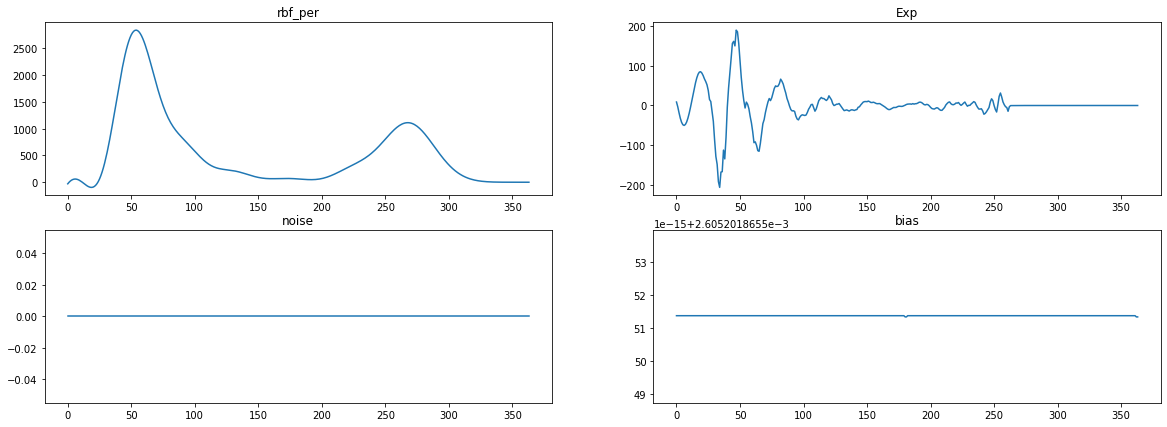

In [ ]:
(# Setup figure environment (4x2 grid)
plt.figure(figsize=(20,7))
X = np.arange(len(gp_data)+100).reshape(-1, 1)

plt.subplot(221)
mean, Cov = m.predict_noiseless(X, kern=m.kernel.rbf_per)
pd.Series(mean[:,0]).plot()
plt.title("rbf_per")

plt.subplot(222)
mean, Cov = m.predict_noiseless(X, kern=m.kernel.exp)
pd.Series(mean[:,0]).plot()
plt.title("Exp")

plt.subplot(223)
mean, Cov = m.predict_noiseless(X, kern=m.kernel.noise)
pd.Series(mean[:,0]).plot()
plt.title("noise")

plt.subplot(224)
mean, Cov = m.predict_noiseless(X, kern=m.kernel.bias)
pd.Series(mean[:,0]).plot()
plt.title("bias")

### Further messing around with GP

In [ ]:
import itertools

first_rbf_length = [10]#*x for x in range(1,3)]
first_rbf_variance = [10] + [20*x for x in range(1,4)]
second_rbf_length = [50*x for x in range(2,6)]
second_rbf_variance = [20*x for x in range(1,6)]

combinations = list(itertools.product(first_rbf_length,
                                      first_rbf_variance,
                                      second_rbf_length,
                                      second_rbf_variance
                                      ))
df_com = pd.DataFrame(combinations)
df_com.iloc[:,3] = df_com.iloc[:,2]
df_com=  df_com.drop_duplicates()

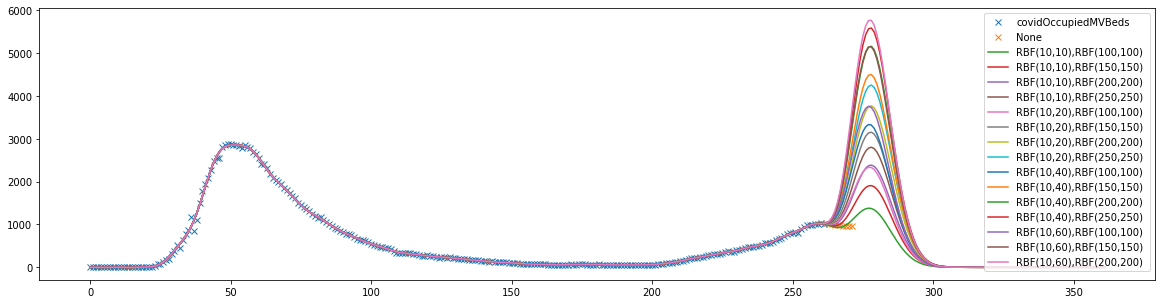

In [ ]:
import GPy
import GPy.likelihoods as likelihoods
import numpy as np

gp_data = pd.concat([df_data[endog_name].dropna()#,df_future_preds.iloc[:,0].dropna()
                      ],axis=0).reset_index(drop=True).values

fig,ax = plt.subplots(figsize=(20,10))
pd.concat([df_data[endog_name].dropna()],axis=0).reset_index(drop=True).plot(marker="x",linewidth=0,ax=ax)
pd.concat([df_data[endog_name].dropna(),df_future_preds.iloc[:,0].dropna()],axis=0).reset_index(drop=True).iloc[-len(df_future_preds):].plot(marker="x",linewidth=0,ax=ax)
for index, rbf_1_length, rbf_1_var, rbf_2_length, rbf_2_var in list(df_com.itertuples())[0:15]:
  kernel = (GPy.kern.RBF(1,lengthscale=rbf_1_length,variance=rbf_1_var)*
            GPy.kern.Matern52(1,lengthscale=rbf_2_length,variance=rbf_2_var)*
            GPy.kern.StdPeriodic(1,variance=200,lengthscale=100, period=200) + GPy.kern.White(1))

  m = GPy.models.GPRegression(X=np.arange(len(gp_data)).reshape(-1, 1),
                    Y=gp_data.reshape(-1, 1),
                    kernel=kernel,
                    normalizer=False,
                    )

  #m.optimize(messages=True);
  predict_mean, predict_cov = m.predict(np.arange(len(gp_data)+100).reshape(-1, 1),full_cov=True)

  pd.Series(predict_mean[:,0],name=f"RBF({rbf_1_length},{rbf_1_var}),RBF({rbf_2_length},{rbf_2_var}) ").plot(figsize=(20,5),ax=ax)

  # plt.fill_between(np.arange(len(predict_mean)),
  #                   predict_mean[:,0] - 1.96*np.sqrt(np.diag(predict_cov)),
  #                   predict_mean[:,0] + 1.96*np.sqrt(np.diag(predict_cov)),
  #                   alpha=0.5)

plt.legend()

In [ ]:
# def plot_gp(X, m, C, training_points=None):
#     """ Plotting utility to plot a GP fit with 95% confidence interval """
#     # Plot 95% confidence interval 
#     plt.fill_between(X[:,0],
#                      m[:,0] - 1.96*np.sqrt(np.diag(C)),
#                      m[:,0] + 1.96*np.sqrt(np.diag(C)),
#                      alpha=0.5)
#     # Plot GP mean and initial training points
#     plt.plot(X, m, "-")
#     plt.legend(labels=["GP fit"])
    
#     plt.xlabel("x"), plt.ylabel("f")
    
#     # Plot training points if included
#     if training_points is not None:
#         X_, Y_ = training_points
#         plt.plot(X_, Y_, "kx", mew=2)
#         plt.legend(labels=["GP fit", "sample points"])

# upper_diff  = predict_mean_diff[:,0] + 1.96*np.sqrt(np.diag(predict_cov_diff))
# lower_diff  = predict_mean_diff[:,0] - 1.96*np.sqrt(np.diag(predict_cov_diff))

# def integrate(differenced_array, start=0):
#   integ = [start]
#   for val in np.ravel(differenced_array):
#     integ.append(integ[-1]+val)
#   return integ

# integ_upper = [0]
# for idx in range(1, len(predict_mean_diff)):
#   integ_upper.append(pd.Series(integrate(predict_mean_diff), name='mean')[idx-1]+upper_diff[idx])
#   print(pd.Series(integrate(predict_mean_diff), name='mean')[idx-1]," : ",upper_diff[idx])


# df_gp_output = pd.concat([
#                           pd.Series(integ_upper, name='upper'),
# #pd.Series(integrate(lower_diff), name='lower'),
# pd.Series(integrate(predict_mean_diff), name='mean')],axis=1)


# #plot_gp(np.arange(len(predict_mean_diff)).reshape(-1,1), predict_mean_diff, predict_cov_diff)
# df_gp_output.plot()

In [ ]:
x_arr = np.array([[0,1,100],[1000,10000,200],[50,150,175]])
def mean_func(x : np.array):
  def f(x):
    return arima_model_fit[x] if x in range(0,len(arima_model_fit)) else 0

  f_v = np.vectorize(f)

  return f_v(x)

mean_func(x_arr)

NameError: ignored

In [ ]:
import GPy

kernel = GPy.kern.RBF(1,variance=1000)

mf = GPy.core.Mapping(1,1)

arima_model_fit = pd.concat([df_insample_preds,df_future_preds],axis=0).reset_index(drop=True).iloc[:,0].values

# def mean_func(x):
#   #print(x)
#   #print(x.shape)
#   3000*np.sin(x/50)
#   #return arima_model_fit[x.astype(int)]
#   return np.array([arima_model_fit[int(x_)] if x_ in range(0,len(arima_model_fit)) else 0 for x_ in x])

def mean_func(x : np.array):
  def f(x):
    if x in range(0,len(arima_model_fit)):
      return arima_model_fit[int(x)]  
    else:
      return 0

  f_v = np.vectorize(f)

  return f_v(x)

mf.f = mean_func
#mf.f = lambda x : arima_model_fit[x]
#mf = None#GPy.mappings.Linear(1,1)
mf.update_gradients = lambda a,b: None

gp_data = df_data[endog_name].dropna().reset_index(drop=True)

m = GPy.models.GPRegression(X=gp_data.index.values.reshape(-1, 1),
                  Y=gp_data.values.reshape(-1, 1),
                  kernel=kernel,
                  normalizer=False,
                  mean_function = mf
                  )

m.optimize(messages=True);
#pd.DataFrame(m.predict(df_data[endog_name].dropna().reset_index(drop=True).index[1:].values.reshape(-1, 1))[0]).plot();
#ax = m.plot(figsize=(10,7.5),plot_density=False)
#plt.ylim(-10,3200)

In [ ]:
predict_mean, predict_cov = m.predict(np.arange(len(gp_data)+100).reshape(-1, 1),full_cov=True)

In [ ]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval
    plt.figure(figsize=(20,5))
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

plot_gp(np.arange(len(predict_mean)).reshape(-1,1), predict_mean, predict_cov)
pd.concat([df_data[endog_name].dropna()#,df_future_preds.iloc[:,0].dropna()
                    ],axis=0).reset_index(drop=True).plot(marker="x",linewidth=0)

In [ ]:
RBF_short = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1., name='short')  # gently sloping - the next value is near the value before
# RBF_long = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=100., name ='long')
# RBF_long.lengthscale.fix()
#linear = (GPy.kern.Linear(1,) + GPy.kern.Bias(1, 1))* GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.) # 
noise = GPy.kern.White(input_dim=1,name='noise') # noise
noise.variance=0.001
noise.fix()
periodic = GPy.kern.Prod([GPy.kern.RBF(input_dim=1, variance=100, lengthscale=10),
                          GPy.kern.StdPeriodic(1,variance=100,lengthscale=10, period=100)],name='periodic') #trying long term repetition
periodic.std_periodic.period.fix()
#periodic.std_periodic.lengthscale.fix()

kernel = GPy.kern.Add([periodic])

gp_data = df_data[endog_name].dropna().reset_index(drop=True)


m = GPy.models.GPRegression(X=gp_data.index.values.reshape(-1, 1),
                  Y=gp_data.values.reshape(-1, 1),
                  kernel=kernel,
                  normalizer=False)
m.optimize(messages=True);
ax = m.plot(figsize=(10,7.5),plot_density=False)
plt.ylim(0,3000)

## NHS England model


### Model Background
Richard's curve : https://en.wikipedia.org/wiki/Generalised_logistic_function#:~:text=The%20generalised%20(generalized)%20logistic%20function,%3D%20time.

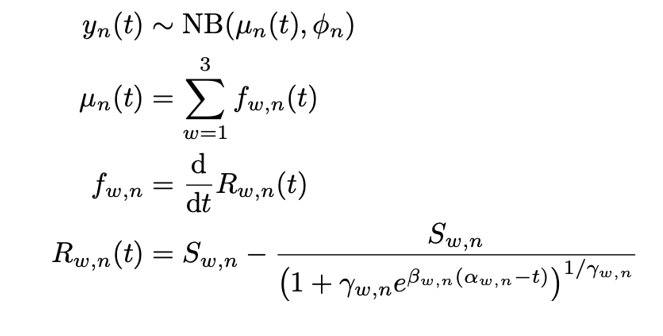

I think maybe they got it wrong above...? This seems more sensible (with the alpha and t reversed:

<a href="https://www.codecogs.com/eqnedit.php?latex=\large&space;R_{w,n}(t)&space;=&space;S_{w,n}&space;-&space;\frac&space;{S_{w,n}}{(1&plus;\gamma_{w,n}e^{\beta_{w,n}(t-\alpha_{w,n})})^{1/\gamma_{w,n}}}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\large&space;R_{w,n}(t)&space;=&space;S_{w,n}&space;-&space;\frac&space;{S_{w,n}}{(1&plus;\gamma_{w,n}e^{\beta_{w,n}(t-\alpha_{w,n})})^{1/\gamma_{w,n}}}" title="\large R_{w,n}(t) = S_{w,n} - \frac {S_{w,n}}{(1+\gamma_{w,n}e^{\beta_{w,n}(t-\alpha_{w,n})})^{1/\gamma_{w,n}}}" /></a>

The above is actually a solution to a differential equation:
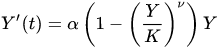

The differential can be put in the form: 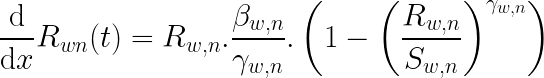

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def richards(t,S,gamma,beta,alpha):
  return S- S / (1 + gamma * np.exp(beta * (alpha-t)))**(1 / gamma)
def richards_grad(t,S, gamma, beta, alpha):
  return -1*(beta/gamma)*(1-(richards(t, S, gamma, beta, alpha)/S)**gamma)*richards(t,S,gamma,beta,alpha)

S = 1000
gamma = 2
beta = -1
alpha = 50
t_max = 140
fig, ax = plt.subplots(2, 3, figsize = (30,10))
for gamma_ in np.round(np.linspace(1,20,5)):
  pd.Series([richards(t, S , gamma_, beta, alpha) for t in range(0,t_max)], name=f'S={S}, g={gamma_}, b={beta}, a={alpha}').plot(legend=True, ax=ax[0][0])
  pd.Series([richards_grad(t, S , gamma_, beta, alpha) for t in range(0,t_max)], name=f'S={S}, g={gamma_}, b={beta}, a={alpha}').plot(legend=True, ax=ax[1][0])
for beta_ in -1*np.logspace(-2,0,5):
  pd.Series([richards(t, S , gamma, beta_, alpha) for t in range(0,t_max)], name=f'S={S}, g={gamma}, b={beta_:.2f}, a={alpha}').plot(legend=True, ax=ax[0][1])
  pd.Series([richards_grad(t, S , gamma, beta_, alpha) for t in range(0,t_max)], name=f'S={S}, g={gamma}, b={beta_:.2f}, a={alpha}').plot(legend=True, ax=ax[1][1])
for alpha_ in np.round(np.linspace(10,100,5)):
  pd.Series([richards(t, S , gamma, beta, alpha_) for t in range(0,t_max)], name=f'S={S}, g={gamma}, b={beta}, a={alpha_}').plot(legend=True, ax=ax[0][2])
  pd.Series([richards_grad(t, S , gamma, beta, alpha_) for t in range(0,t_max)], name=f'S={S}, g={gamma}, b={beta}, a={alpha_}').plot(legend=True, ax=ax[1][2])

In [ ]:
data_raw.reset_index(drop=False).newAdmissions.plot()

In [ ]:
initial_guess_w1 = dict(S = 80_000,gamma = 9.0,beta = -0.5,alpha = 10,)
initial_guess_w2 = dict(S = 10_000,gamma = 9.0,beta = -0.5,alpha = 40,)
pd.Series([richards_grad(t, **initial_guess_w1) for t in range(0,t_max)], name=f'S={S}, g={gamma}, b={beta}, a={alpha}').plot(legend=True)
pd.Series([richards_grad(t, **initial_guess_w2) for t in range(0,t_max)], name=f'S={S}, g={gamma}, b={beta}, a={alpha}').plot(legend=True)

In their model the values are somewhat empirical, but Alpha is the rough time of the peak, then beta and gamma determine the size and skew. 

### Fitting the model

#### First using SciPy optimize

In [ ]:
def two_peaks_model(t, S1,gamma1,beta1,alpha1,S2,gamma2,beta2,alpha2):
  return richards_grad(t, S1,gamma1,beta1,alpha1) + richards_grad(alpha1,S2,gamma2,beta2,alpha2)

In [ ]:
import scipy
import scipy.optimize as opt
x_data = np.atleast_1d(data_raw.iloc[:150,:].reset_index().index)
y_data = np.atleast_1d(data_raw.iloc[:150,:].newAdmissions)
w1 = pd.Series(initial_guess_w1)
w2 = pd.Series(initial_guess_w2)
p0 = w1.append(w2).values

popt, pcov = opt.curve_fit(two_peaks_model, x_data, y_data,p0=p0)

pd.Series([two_peaks_model(t, *popt) for t in range(0,len(data_raw))], name=f'opt').plot(legend=True)
data_raw.reset_index(drop=False).newAdmissions.plot()

#### BAyesian model


##### Pystan


In [ ]:
pip install pystan

In [ ]:
# import pystan

# schools_code = """
# data {
#     int<lower=0> J; // number of schools
#     vector[J] y; // estimated treatment effects
#     vector<lower=0>[J] sigma; // s.e. of effect estimates
# }
# parameters {
#     real mu;
#     real<lower=0> tau;
#     vector[J] eta;
# }
# transformed parameters {
#     vector[J] theta;
#     theta = mu + tau * eta;
# }
# model {
#     eta ~ normal(0, 1);
#     y ~ normal(theta, sigma);
# }
# """

# schools_dat = {'J': 8,
#                'y': [28,  8, -3,  7, -1,  1, 18, 12],
#                'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

# sm = pystan.StanModel(model_code=schools_code)
# fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

# fit.plot()

##### install pymc3

In [ ]:
pip install pymc3

##### set up the model

In [ ]:
import pymc3 as pm
import theano

observed_data = data_raw.newAdmissions.copy().reset_index(drop=True).iloc[0:100]#.values
t_values = observed_data.index.values

with pm.Model() as hierarchical_model:
    # Hyperpriors for group (i.e. National) - these are the group means and sigmas
    # So here we describe the national mean S and national variance in S, etc.
    t = pm.Data("t", t_values)

    mu_S = pm.Normal('mu_S', mu=80_000., sigma=80_000)
    #sigma_S = pm.HalfNormal('sigma_S', 5.)
    mu_gamma = pm.Normal('mu_gamma', mu=9., sigma=20.0)
    #sigma_gamma = pm.HalfNormal('sigma_gamma', 5.)
    #mu_beta = pm.Normal('mu_beta', mu=-0.5, sigma=3.0)
    mu_beta = pm.Lognormal('mu_beta', mu=-0.5, sigma=5.0)
    #sigma_beta = pm.HalfNormal('sigma_beta', 5.)
    mu_alpha = pm.Normal('mu_alpha', mu=10., sigma=200)
    #sigma_alpha = pm.HalfNormal('sigma_alpha', 5.)

    # Hyperpriors for local (i.e. trust) - these are sampled around the national values (with a length of N trusts)
    # So we get a value of gamma for each trust, a value of beta for each trust and so forth.
    # Population, S, will need to be handled different as that isn't linked between the areas....
    # a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_counties)
    # # Intercept for each county, distributed around group mean mu_a
    # b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    import theano.tensor as T

    def richards_T(t,S,gamma,beta,alpha):
      return S- S / (1 + gamma * T.exp(beta * (alpha-t)))**(1 / gamma)
    def richards_grad_T(t,S, gamma, beta, alpha):
      return -1*(beta/gamma)*(1-(richards(t, S, gamma, beta, alpha)/S)**gamma)*richards_T(t,S,gamma,beta,alpha)
    #beds_est = pd.Series([richards_grad(t, mu_S, mu_gamma, mu_beta, mu_alpha) for t in range(0,len(data_raw))]).values
    beds_est = richards_grad_T(t, mu_S, mu_gamma, mu_beta, mu_alpha)
    # Data likelihood

    #observed_data = data_raw.newAdmissions.copy()#.astype(theano.config.floatX)

    beds_like = pm.Normal('beds_like', mu=beds_est,
                          sigma=eps, observed=observed_data
     )
    
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)

In [ ]:
# # Inference button (TM)!
# with hierarchical_model:
#     hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)

In [ ]:
map_estimate = pm.find_MAP(model=hierarchical_model)
map_estimate

In [ ]:
sample_posterior = pm.sample_posterior_predictive(model=hierarchical_model, trace=hierarchical_trace)

In [ ]:
def richards(t,S,gamma,beta,alpha):
  return S- S / (1 + gamma * np.exp(beta * (alpha-t)))**(1 / gamma)
def richards_grad(t,S, gamma, beta, alpha):
  return -1*(beta/gamma)*(1-(richards(t, S, gamma, beta, alpha)/S)**gamma)*richards(t,S,gamma,beta,alpha)

t_out_of_sample = np.arange(len(t_values), len(t_values) + 100)

# beds out of sample used???
beds_out_of_sample = pd.Series([richards_grad(t_, map_estimate['mu_S'], map_estimate['mu_gamma'], map_estimate['mu_beta_log__'], map_estimate['mu_alpha']) for t_ in t_out_of_sample])

# this bit is where it takes the out of sample t, and then samples from the posterior get the predictions
with hierarchical_model:
    pm.set_data({"t": t_out_of_sample})
    model_preds = pm.sample_posterior_predictive(
        hierarchical_trace
    )

In [ ]:
lower_post_pred = np.percentile(model_preds["beds_like"],q=2.5,axis=0)  # grab lower 2.5% quantiles
upper_post_pred = np.percentile(model_preds["beds_like"],q=97.5,axis=0)  # grab Upper 92.5% quantiles
mean_post_pred = np.mean(model_preds["beds_like"], axis=0) # Media
lower_post_insample_pred = np.percentile(sample_posterior["beds_like"],q=2.5,axis=0)  # grab lower 2.5% quantiles
upper_post_insample_pred = np.percentile(sample_posterior["beds_like"],q=97.5,axis=0)  # grab Upper 92.5% quantiles
mean_post_insample_pred = np.mean(sample_posterior["beds_like"], axis=0) # Media

fig, ax = plt.subplots(figsize=(20,5))
data_raw.reset_index(drop=True).newAdmissions.rename('Observed Data').plot(color='black',marker='+',linewidth=0, alpha=0.5);
pd.Series(mean_post_pred, index=t_out_of_sample,name='Out of sample predictions').plot();
pd.Series(mean_post_insample_pred, index=t_values, name='In sample "predictions"').plot();
plt.fill_between(t_out_of_sample, upper_post_pred, lower_post_pred,
                facecolor='grey', alpha=0.2, interpolate=True);
plt.fill_between(t_values, upper_post_insample_pred, lower_post_insample_pred,
                facecolor='green', alpha=0.2, interpolate=True);
plt.legend()


In [ ]:
params = pd.DataFrame(dict(S = hierarchical_trace['mu_S'], gamma = hierarchical_trace['mu_gamma'],beta = hierarchical_trace['mu_beta'], alpha = hierarchical_trace['mu_alpha']))

def richards(t,S,gamma,beta,alpha):
  return S- S / (1 + gamma * np.exp(beta * (alpha-t)))**(1 / gamma)
def richards_grad(t,S, gamma, beta, alpha):
  return -1*(beta/gamma)*(1-(richards(t, S, gamma, beta, alpha)/S)**gamma)*richards(t,S,gamma,beta,alpha)

data_raw.reset_index(drop=True).newAdmissions.plot()
for idx, param in params.iterrows():
  sample_plot_data = pd.Series([richards_grad(t, **param) for t in range(0,len(data_raw))]).plot(alpha=0.1, linestyle = '--')

## SEIR model

The first part of the cambridge model is an SEIR model

- **Susceptible** - people that can be infected, i.e. the population
- **Exposed** - people that have the virus, but are not yet infections (incubation)
- **Infected** - people that have the virus and **are infectious**
- **Hospitalised** - people that are subsequently hospitalised
- **Critical** - people that are subsequently moved to critical care
- **Dead** - people that died - either after infection, hospitalisation or critical care
- **Recovered** - people that recover from infection after either infection, hospitalisation or critical care

      S -> E -> I -> R
                  -> H -> R
                       -> D
                  -> H -> C -> R
                       -> C -> D

People move between the comparments with rates and probabilities

- beta: the rate at which people become exposed (contact rate) - how many people an exposed person will come into contact with
- sigma: the rate at which exposed people become infections (1 / incubation period)
- gamma: the rate at which people recover (1 / usual illness period)

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [ ]:
!pip install lmfit

In [ ]:
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import numpy as np

np.random.seed(42)
x = np.linspace(1, 20.0, 1001)

data = (gaussian(x, 21, 6.1, 1.2) + np.random.normal(scale=0.1, size=x.size))  # normal distr. with some noise
def f(x, a, b, c):
    return gaussian(x, a, b, c)

def logistic(x,a,b,c):
    return 1/(1-a*np.exp(b*(c-x)))**(1/a)

mod = lmfit.Model(logistic)
# we set the parameters (and some initial parameter guesses)
mod.set_param_hint("a", value=1/9.0, vary=True)
mod.set_param_hint("b", value=2.0, vary=True)
mod.set_param_hint("c", value=10.0, vary=True)

params = mod.make_params()
result = mod.fit(data, params, method="leastsq", x=x)  # fitting
result.plot_fit(datafmt="-");

In [ ]:
def deriv(y, t, beta, gamma, sigma, N, Beds):
    S, E, I, H, C, R, D = y

    p_I_to_H = 1/10.0 # 10% of people? -> needs to be age dependent
    r_I_to_H = 1/12.0 # twelve days
    p_I_to_R = 1 - p_I_to_H
    r_H_to_C = 1/7.0 # go to critical care after one week
    p_H_to_C = 1/10.0 # 10% of people go to critical
    p_H_to_D = 1/100 # 1 in 100 die from hospital
    r_H_to_D = 1/3.0 # over three days they might die so quickly (guess!)
    p_H_to_R = 1 - p_H_to_C # - p_H_to_D
    r_H_to_R = 1/6.5 # 1 week in hospital to recovery
    p_C_to_D = 0.4 # 40% die in critical
    r_C_to_D = 1/7.5
    p_C_to_R = 1 - p_C_to_D
    r_C_to_R = 1/6.5
    C_bed_cap = min(Beds(t),C) # C capped at the number of Beds -> can't have more people than beds
    C_bed_overflow = max(0, C - Beds(t)) # the difference between C and the Beds (floored at 0) -> these guys die
    H_bed_cap = H #min(H_Beds(t), H) # -> assume infinite hospital beds
    H_bed_overflow = 0 #max(0,H - H_Beds(t)) # -> assume infinite hosp beds so no overflow

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = (sigma * E 
            - r_I_to_H * p_I_to_H * I  # -> I to hospital
            - gamma * p_I_to_R * I) # -> I to recovered
    dHdt = (r_I_to_H * p_I_to_H * I # people arrive from infected
            - r_H_to_C * p_H_to_C * H_bed_cap # -> Hospital to Critical Care
            - r_H_to_D * p_H_to_D * H_bed_cap # -> hospital to dead for people with a bed
            #- 1 * 1 * H_bed_overflow # -> hospital to dead for people without a bed (100%)
            - r_H_to_R * p_H_to_R * H_bed_cap) # Hospital to recovered with a bed
    dCdt = (r_H_to_C * p_H_to_C * H_bed_cap # people arrive from hospital
            - r_C_to_D * p_C_to_D * C_bed_cap # critical to dead with a bed
            - 1 * 1 * C_bed_overflow #  critical to dead without a bed (100%)
            - p_C_to_R * r_C_to_R * C_bed_cap # critical to recover with bed (not likely normally, however assumption that simplifies the model)
    )
    dRdt = (p_I_to_R * gamma * I # Infected to Recover
           + p_H_to_R * r_H_to_R * H_bed_cap # Hospital to recover
           + p_C_to_R * r_C_to_R * C_bed_cap # Critical to recover
           )
    dDdt = (r_H_to_D * p_H_to_D * H_bed_cap # hostpial to dead with a bed 
           + r_C_to_D * p_C_to_D * C_bed_cap  # critical to dead with a bed
           #+ 1 * 1 * H_bed_overflow # hospital to dead, no bed (100%)
           + 1 * 1 * C_bed_overflow # critical to dead, no bed (100%)
           )
    dydt = pd.Series(dict(dSdt=dSdt, dEdt=dEdt, dIdt=dIdt, dHdt=dHdt, dCdt=dCdt, dRdt=dRdt, dDdt=dDdt))
    #print(dydt.sum(), end=', ') # I've get extra people!!! Need to reformulate the equations so that doesn't happen...
    return dydt

In [ ]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

In [ ]:
def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    #y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    y0 = pd.Series(dict(S = N-1, E = 30, I=0, H=0, C=0, R=0, D=0))
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0.tolist(), t, args=(beta, gamma, sigma, N, Beds))
    S, E, I, H, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    Beds = [Beds(i) for i in range(len(t))]
    
    probs = dict()
    rates = dict()
    return dict(t=t, S=S, E=E, I=I,H=H, C=C, R=R, D=D, R_0=R_0_over_time, B=Beds, probs=probs, rates=rates)

In [ ]:
def plotter(model_result,#t, S, E, I, H, C, R, D, R_0, B, probs, rates, 
            x_ticks=None):
    fig, ax = plt.subplots(2,3,figsize=(30,10))
    plot_x = model_result['t'] if x_ticks is None else x_ticks
    plot_kwargs = dict(alpha=0.7, linewidth=2,)
    plot_max = [model_result['S'].max()*1.05, model_result['I'].max()*1.05, model_result['D'].max()*1.05]
    for idx, ax_ in enumerate(ax[0]):
        ax_.plot(plot_x, model_result['S'], 'b', **plot_kwargs, label='Susceptible')
        ax_.plot(plot_x, model_result['E'], 'y', **plot_kwargs, label='Exposed')
        ax_.plot(plot_x, model_result['I'], 'r', **plot_kwargs, label='Infected')
        ax_.plot(plot_x, model_result['H'], 'r:', **plot_kwargs, label='Hospital')
        ax_.plot(plot_x, model_result['C'], 'r--', **plot_kwargs, label='Critical')
        ax_.plot(plot_x, model_result['R'], 'g', **plot_kwargs, label='Recovered')
        ax_.plot(plot_x, model_result['D'], 'k', **plot_kwargs, label='Dead')
        pd.DataFrame(dict(S=model_result['S'],E=model_result['E'],I=model_result['I'],H=model_result['H'],C=model_result['C'],
                          R=model_result['R'],D=model_result['D']),index=pd.Series(model_result['t'],name='t')).sum(axis=1).rename("Total").plot(ax=ax_)
        ax_.set_ylim(0,plot_max[idx])
        ax_.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax_.legend()
        legend.get_frame().set_alpha(0.5)
    
    fig.suptitle('extended SEIR-Model')

    ax[1][0].plot(plot_x, model_result['B'], 'b', **plot_kwargs, label='Beds')
    ax[1][0].legend()
    ax[1][1].plot(plot_x, model_result['R_0'], 'r', **plot_kwargs, label='R_0')
    ax[1][1].legend()

    # for spine in ('top', 'right', 'bottom', 'left'):
    #     ax.spines[spine].set_visible(False)
    plt.show();

In [ ]:
plotter(Model(days=500, agegroups=[60_000_000], 
               beds_per_100k= 50
                , R_0_start=4.0, k=1.0, x0=60, R_0_end=1.0, s=0.003)
        )

## Gaussian Processes

These aren't as complex as they first appear. Basically, it's a bayesian method which produces distributions of functions defined by two things:

the mean function (which describes the trend of all these functions)
the kernel (which describes the distance these functions can be from the mean).
Notation of Gaussian process is like this: GP(mean, K)

To use this to make predictions you define the form of the gaussian process (Which is basically the kernel you want it to have), and then you fit it to your "X" (i.e. time) and your "y" (i.e. hospitalisations). This fitting process works out the mean function. You can then make predictions by supplying a set of X_pred and get corresponding y_pred.

Some example code is below, fitting a gaussian process to hospital data:

In [ ]:
from typing import Iterable, Dict, Union, List
from json import dumps
from requests import get
from http import HTTPStatus
import pandas as pd


StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]


def get_paginated_dataset(filters: FiltersType, structure: StructureType,
                          ) -> APIResponseType:
    """
    Extracts paginated data by requesting all of the pages
    and combining the results.

    Parameters
    ----------
    filters: Iterable[str]
        API filters. See the API documentations for additional
        information.

    structure: Dict[str, Union[dict, str]]
        Structure parameter. See the API documentations for
        additional information.

    Returns
    -------
    pd.DataFrame
        The data for the given ``filters`` and ``structure``.
    """
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
    api_params = dict(filters=str.join(";", filters),
                      structure=dumps(structure, separators=(",", ":")), 
                      format="json", page=1)
    data = list()
    page_number = 1
    current_data = dict(pagination={'next':True}) # dummy initial "next" pagination

    while current_data["pagination"]["next"] is not None:
        api_params["page"] = page_number
        response = get(endpoint, params=api_params, timeout=10)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        current_data = response.json()
        page_data: List[StructureType] = current_data['data']
        
        data.extend(page_data)

        page_number += 1

    return pd.DataFrame(data)


if __name__ == "__main__":
    query_filters = [
        f"areaType=nation;areaName=england"
    ]

    query_structure = {
        "date": "date",
        "name": "areaName",
        "code": "areaCode",
        "newAdmissions": "newAdmissions",
    }

  # newCasesByPublishDate - New cases by publish date
  # cumCasesByPublishDate - Cumulative cases by publish date
  # cumCasesBySpecimenDateRate - Rate of cumulative cases by publish date per 100k resident population
  # newCasesBySpecimenDate - New cases by specimen date
  # cumCasesBySpecimenDateRate - Rate of cumulative cases by specimen date per 100k resident population
  # cumCasesBySpecimenDate - Cumulative cases by specimen date
  # maleCases - Male cases (by age)
  # femaleCases - Female cases (by age)
  # newPillarOneTestsByPublishDate - New pillar one tests by publish date
  # cumPillarOneTestsByPublishDate - Cumulative pillar one tests by publish date
  # newPillarTwoTestsByPublishDate - New pillar two tests by publish date
  # cumPillarTwoTestsByPublishDate - Cumulative pillar two tests by publish date
  # newPillarThreeTestsByPublishDate - New pillar three tests by publish date
  # cumPillarThreeTestsByPublishDate - Cumulative pillar three tests by publish date
  # newPillarFourTestsByPublishDate - New pillar four tests by publish date
  # cumPillarFourTestsByPublishDate - Cumulative pillar four tests by publish date
  # newAdmissions - New admissions
  # cumAdmissions - Cumulative number of admissions
  # cumAdmissionsByAge - Cumulative admissions by age
  # cumTestsByPublishDate - Cumulative tests by publish date
  # newTestsByPublishDate - New tests by publish date
  # covidOccupiedMVBeds - COVID-19 occupied beds with mechanical ventilators
  # hospitalCases - Hospital cases
  # plannedCapacityByPublishDate - Planned capacity by publish date
  # newDeaths28DaysByPublishDate - Deaths within 28 days of positive test
  # cumDeaths28DaysByPublishDate - Cumulative deaths within 28 days of positive test
  # cumDeaths28DaysByPublishDateRate - Rate of cumulative deaths within 28 days of positive test per 100k resident population
  # newDeaths28DaysByDeathDate - Deaths within 28 days of positive test by death date
  # cumDeaths28DaysByDeathDate - Cumulative deaths within 28 days of positive test by death date
  # cumDeaths28DaysByDeathDateRate - Rate of cumulative deaths within 28 days of positive test by death date per 100k resident population

    data_raw = get_paginated_dataset(query_filters, query_structure)



/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


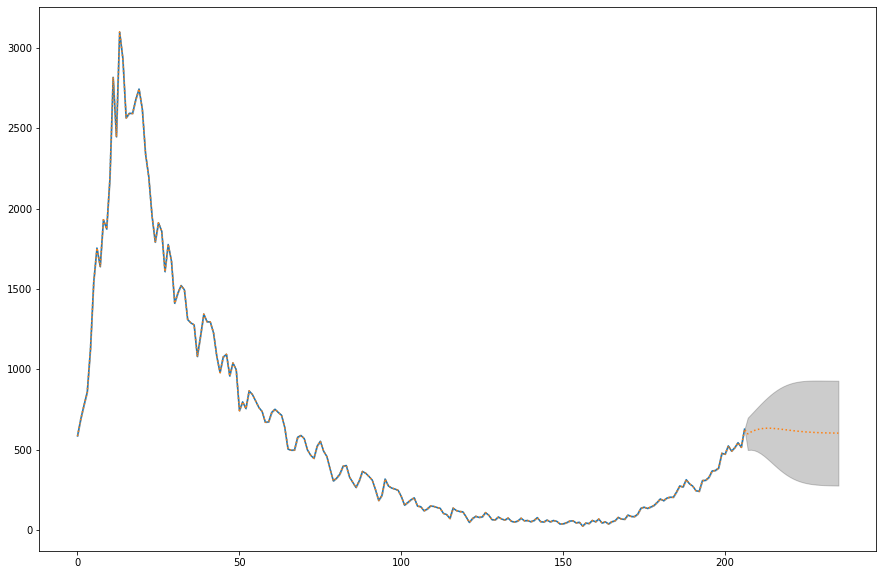

In [ ]:
import sklearn.gaussian_process as skl_gp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)

data = data_raw.assign(date=pd.to_datetime(data_raw['date'])).sort_values('date').reset_index(drop=True).iloc[:-10,:]
data.tail()

# The kernel is critical!!!!!
kernel = ConstantKernel(0.1, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))
          #      * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
          #  1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
          #               nu=1.5)
# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k1 + k2 + k3 + k4
model = skl_gp.GaussianProcessRegressor(kernel=kernel_gpml,normalize_y=True,n_restarts_optimizer=10)

X_pred = np.atleast_2d(np.arange(data.index[0], data.index[-1]+30)).T
model.fit(data.index.values.reshape(-1, 1),data.newAdmissions.values.reshape(-1, 1))
y_pred, y_std = model.predict(X_pred, return_std=True)
pred_data = pd.DataFrame(index=X_pred.ravel()).assign(newAdmissions=y_pred,newAdmissions_std=y_std)

data['newAdmissions'].plot(figsize=(15,10))
pred_data['newAdmissions'].plot(linestyle=':')
plt.fill_between(pred_data.index.to_list(), pred_data.newAdmissions - pred_data.newAdmissions_std, pred_data.newAdmissions + pred_data.newAdmissions_std,
                     alpha=0.2, color='k')

In [ ]:
pip install gpy

     |████████████████████████████████| 1.0MB 5.6MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
  Created wheel for gpy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633967 sha256=63a62f1a88db71a7975475bd9190c04ab4ce2d3dd9f699d874e8607e43b232a8
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=4ad10263b8b4555f7ca738ff026f556d1838b8856999a452ae43405a067f8976
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built gpy paramz


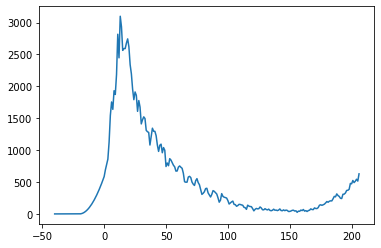

In [ ]:
data_plus_0_point = pd.concat([pd.DataFrame(index=range(data.index[0]-40,data.index[0]-1)),data])
data_plus_0_point.loc[[-40,-20],'newAdmissions'] = 0
data_plus_0_point['newAdmissions'] = data_plus_0_point.newAdmissions.interpolate(method='pchip', limit_direction='both', limit=None)
data_plus_0_point['newAdmissions'].plot()

 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


(-10.0, 3200.0)

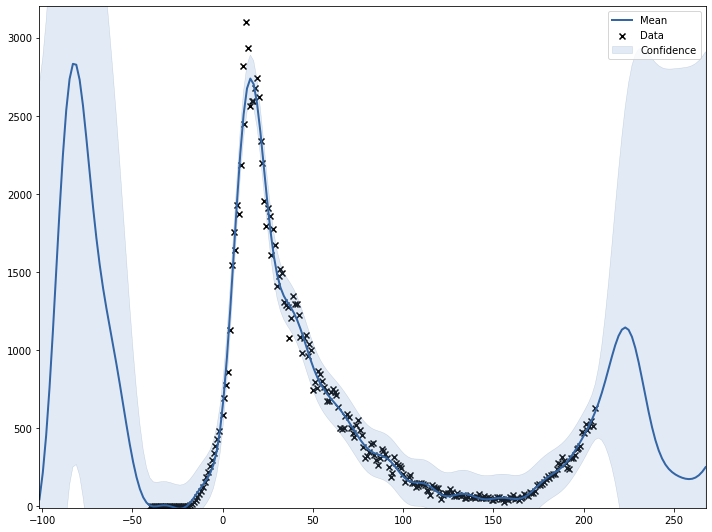

In [ ]:
import GPy
from IPython.display import display

RBF_short = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1., name='short')  # gently sloping - the next value is near the value before
# RBF_long = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=100., name ='long')
# RBF_long.lengthscale.fix()
#linear = (GPy.kern.Linear(1,) + GPy.kern.Bias(1, 1))* GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.) # 
noise = GPy.kern.White(input_dim=1,name='noise') # noise
noise.variance=0.001
noise.fix()
periodic = GPy.kern.Prod([GPy.kern.RBF(input_dim=1, variance=100, lengthscale=10),
                          GPy.kern.StdPeriodic(1,variance=100,lengthscale=10, period=100)],name='periodic') #trying long term repetition
periodic.std_periodic.period.fix()
#periodic.std_periodic.lengthscale.fix()

kernel = GPy.kern.Add([periodic])

m = GPy.models.GPRegression(X=data_plus_0_point.index.values.reshape(-1, 1),
                  Y=data_plus_0_point[['newAdmissions']].values,
                  kernel=kernel,
                  normalizer=True)
m.optimize(messages=True);
ax = m.plot(figsize=(10,7.5),plot_density=False)
#plt.xlim(-40,data.index[-1]+21)
plt.ylim(-10,3200)

{'covariance': [[<matplotlib.lines.Line2D at 0x7f0f032519b0>]]}

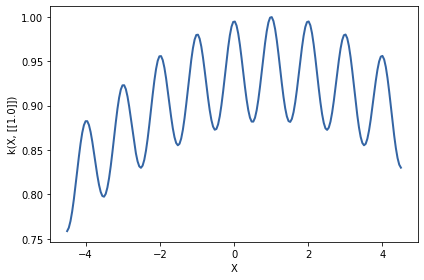

In [ ]:
 GPy.kern.Prod([GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1e1),
                          GPy.kern.StdPeriodic(1,variance=1.,lengthscale=2, period=1.)]).plot()#plot_limits=np.array([-100,300]))

(-10.0, 3200.0)

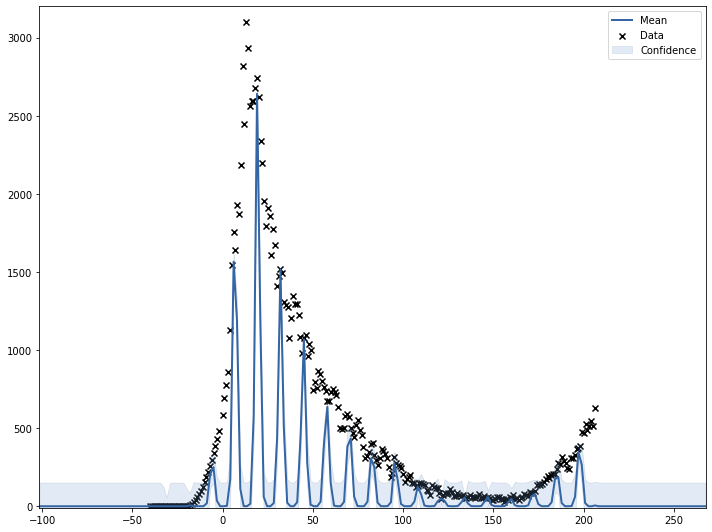

In [ ]:
ax = m.plot(figsize=(10,7.5),plot_density=False)
#plt.xlim(-40,data.index[-1]+21)
plt.ylim(-10,3200)

 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:overflow encountered in square


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f6d04c62710>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f6d050ee6a0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f6d050ee908>]]}

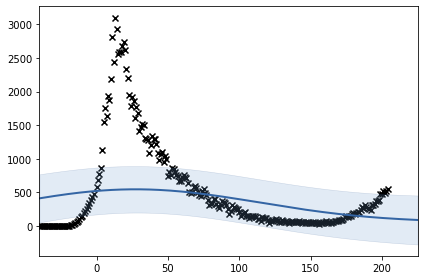

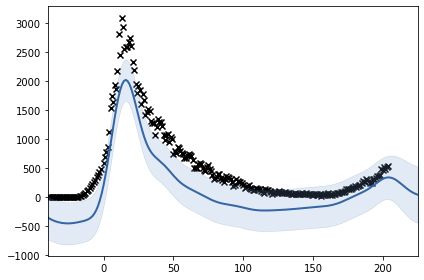

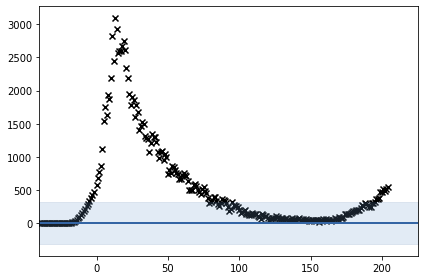

In [ ]:
m.plot(plot_limits=[-40,data.index[-1]+21],predict_kw=dict(kern=m.kern.long),plot_data=True, legend=False);
m.plot(plot_limits=[-40,data.index[-1]+21],predict_kw=dict(kern=m.kern.short),plot_data=True, legend=False);
m.plot(plot_limits=[-40,data.index[-1]+21],predict_kw=dict(kern=m.kern.periodic),plot_data=True, legend=False)
#m.plot(plot_limits=[-40,data.index[-1]+21],predict_kw=dict(kern=m.kern.noise),plot_data=True, legend=False)

 /usr/local/lib/python3.6/dist-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:overflow encountered in square


(-10.0, 3200.0)

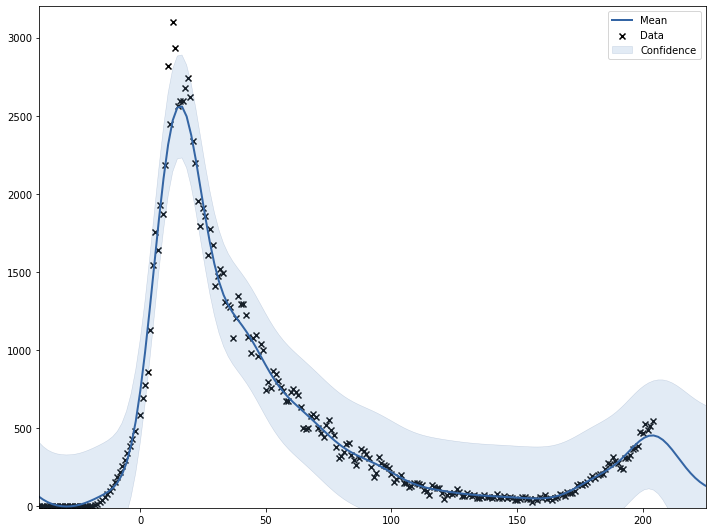

In [ ]:
ax = m.plot(figsize=(10,7.5),plot_density=False)
plt.xlim(-40,data.index[-1]+21)
plt.ylim(-10,3200)

In [ ]:
kernel_pairs = [(k_1, k_2) for k_1 in ["RBF", "linear", "seasonal", "white", "Mat"] for k_2 in ["RBF", "linear", "seasonal", "white", "Mat"]]
kernel_pairs
k1 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)  # gently sloping - the next value is near the value before
k2 = GPy.kern.Linear(1) * GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
k3 = GPy.kern.ExpQuad(input_dim=1, lengthscale=7)
k4 = GPy.kern.White(input_dim=1)
k5 = GPy.kern.Matern32(1, 0.5, 0.2)
kernels = dict(RBF=k1, linear=k2, seasonal=k3, white=k4, Mat=k5)

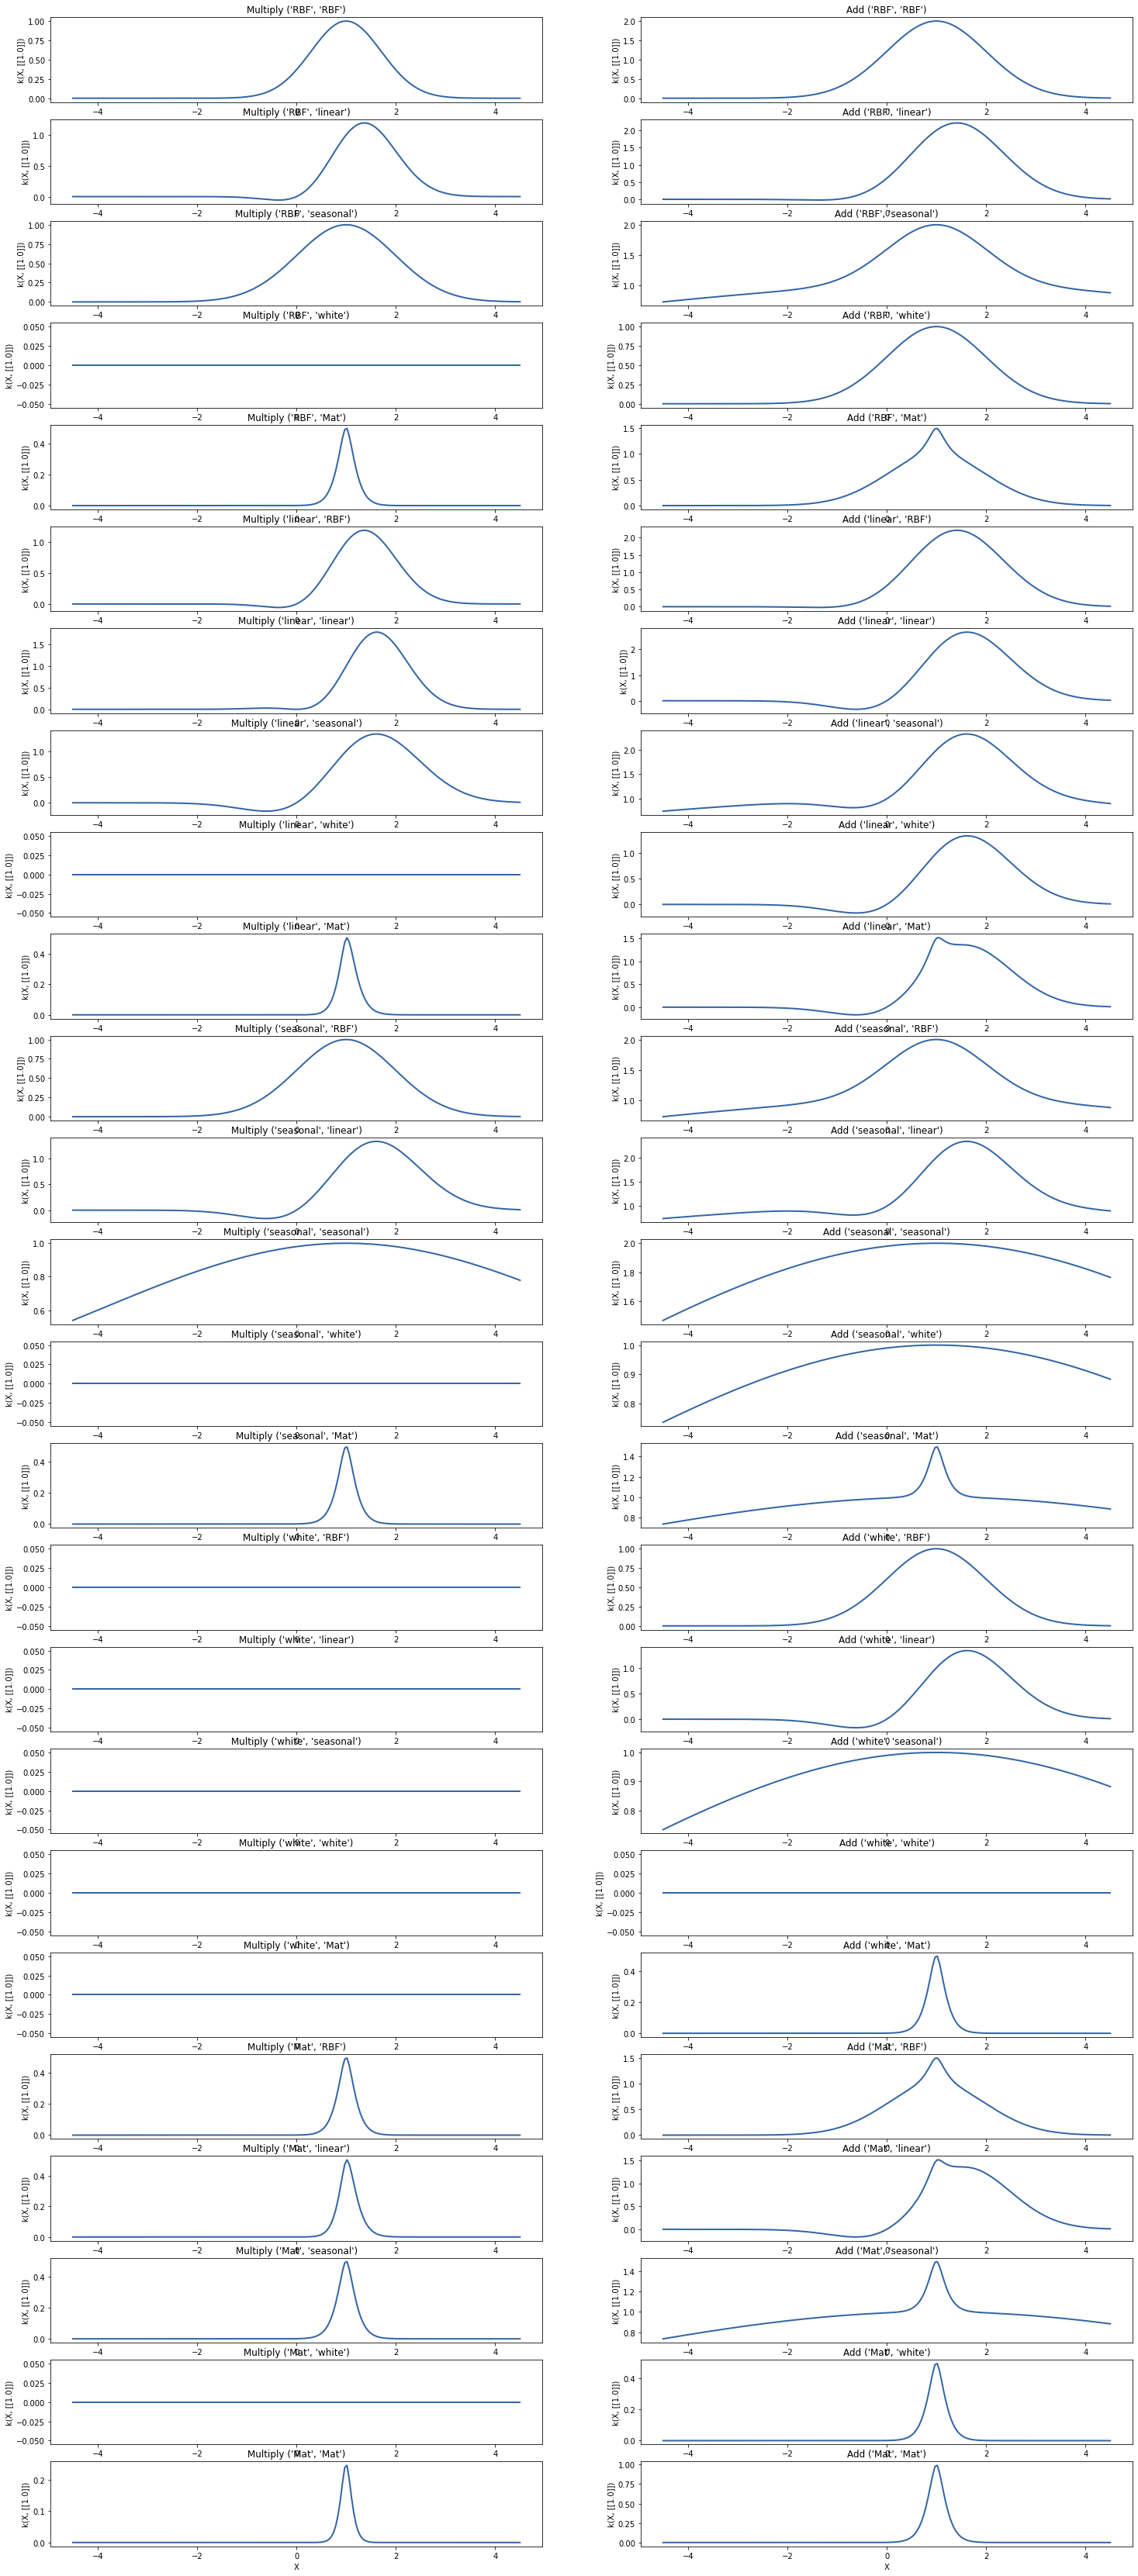

In [ ]:
fig, ax = plt.subplots(len(kernel_pairs),2, figsize=(25,60))
for idx, kernel_pair in enumerate(kernel_pairs):
  ax_ = ax[idx]

  k_prod = kernels[kernel_pair[0]]*kernels[kernel_pair[1]]
  ax_[0].set_title(f"Multiply {kernel_pair}")
  k_prod.plot(ax=ax_[0])
  
  k_add = kernels[kernel_pair[0]] + kernels[kernel_pair[1]]
  ax_[1].set_title(f"Add {kernel_pair}")
  k_add.plot(ax=ax_[1])
